## 1. Import and explore data
<p>By <a href="https://patrio.blog/">Patrik Drhlík</a></p>
<p><em>Warning: the dataset used in this project contains explicit language.</em></p>
<p><img src="https://assets.datacamp.com/production/project_561/img/southpark.png" alt></p>
<p><a href="https://en.m.wikipedia.org/wiki/South_Park">South Park</a> is a satiric American TV show. It is an adult show mainly because of its coarse language. I know every episode pretty well, but I wanted to see if I can dig up something more using text analysis.</p>
<p>That's what we will focus on. We will see how the sentiments and the popularity of episodes evolve over time. We will examine the <strong>swear words</strong> and their ratio across episodes. We will also answer some questions about the show. Do you think that naughtier episodes tend to be more popular? Is Eric Cartman, the main face of the show, really the naughtiest character? We will have answers to these and more questions soon enough.</p>
<p>We will be using two datasets. One that contains every line spoken in all the 287 episodes (first 21 seasons) of the show and another that contains mean episode ratings from <a href="https://www.imdb.com/title/tt0121955">IMDB</a>. We will be joining, summarizing and visualizing until we've answered all our questions.</p>
<p>Our best friends will be the <strong>tidyverse</strong>, <strong>tidytext</strong>, and <strong>ggplot2</strong> packages. Let's not waste any more time and get to it. We'll start slowly by loading all necessary libraries and both of the datasets.</p>

In [155]:
# Load libraries
library(dplyr)
library(readr)
library(tidytext)
library(sweary)

# Load datasets
sp_lines <- read_csv('datasets/sp_lines.csv')
sp_ratings <- read_csv('datasets/sp_ratings.csv')

# Take a look at the last six observations
tail(sp_lines)
tail(sp_ratings)

Parsed with column specification:
cols(
  character = col_character(),
  text = col_character(),
  episode_name = col_character(),
  season_number = col_double(),
  episode_number = col_double()
)
Parsed with column specification:
cols(
  season_number = col_double(),
  episode_number = col_double(),
  rating = col_double(),
  votes = col_double(),
  episode_order = col_double()
)


character,text,episode_name,season_number,episode_number
<chr>,<chr>,<chr>,<dbl>,<dbl>
officer bright,he broke free,Splatty Tomato,21,10
jimbo,the president is on the loose again,Splatty Tomato,21,10
officer bright,he'll be even more desperate now it's going to get worse,Splatty Tomato,21,10
stan,we can't destroy him can we,Splatty Tomato,21,10
randy,i don't know i guess it's up to the whites,Splatty Tomato,21,10
end of splatty tomato,end of splatty tomato,Splatty Tomato,21,10


season_number,episode_number,rating,votes,episode_order
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21,5,7.4,1091,282
21,6,7.3,964,283
21,7,7.4,1008,284
21,8,7.2,833,285
21,9,7.9,896,286
21,10,7.1,906,287


## 2. Sentiments, swear words, and stemming
<p>Now that we have the raw data prepared, we will do some modifications. We'll utilize the combined powers of tidyverse and tidytext and make one great dataset that we will work with from now on.</p>
<p>We will join the dataset together. But most importantly, we will unnest the lines so <strong>every row of our data frame becomes a word</strong>. It will make our analysis and future visualizations very easy. We will also get rid of stop words (a, the, and, …) and assign a sentiment score based on the <a href="http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010">AFINN lexicon</a>.</p>
<p>Our new dataset will have some great new columns that will tell us a lot more about the show!</p>

In [157]:
# Load english swear words
en_swear_words <- sweary::get_swearwords("en") %>%
    mutate(stem = SnowballC::wordStem(word))

# Load the AFINN lexicon
afinn  <- read_rds("datasets/afinn.rds")


# Join lines with episode ratings
sp <- inner_join(sp_lines,sp_ratings)

# Unnest lines to words, leave out stop words and add a 
# swear_word logical column
sp_words <- sp %>%
    unnest_tokens(word, text) %>%
    anti_join(stop_words) %>%
    left_join(afinn) %>%
    mutate(word_stem = SnowballC::wordStem(word),
           swear_word = word %in% en_swear_words$word | word_stem  %in% en_swear_words$stem)

# View the last six observations
tail(sp_words)

Joining, by = c("season_number", "episode_number")
Joining, by = "word"
Joining, by = "word"


character,episode_name,season_number,episode_number,rating,votes,episode_order,word,value,word_stem,swear_word
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<lgl>
officer bright,Splatty Tomato,21,10,7.1,906,287,worse,-3,wors,FALSE
stan,Splatty Tomato,21,10,7.1,906,287,destroy,-3,destroi,FALSE
randy,Splatty Tomato,21,10,7.1,906,287,guess,NA,guess,FALSE
randy,Splatty Tomato,21,10,7.1,906,287,whites,NA,white,FALSE
end of splatty tomato,Splatty Tomato,21,10,7.1,906,287,splatty,NA,splatti,FALSE
end of splatty tomato,Splatty Tomato,21,10,7.1,906,287,tomato,NA,tomato,FALSE


## 3. Summarize data by episode
<p>Now that the dataset is prepared, we can finally start analyzing it. Let's see what we can say about each of the episodes. I can't wait to see the different swear word ratios. What's the naughtiest one?</p>

In [159]:
# Group by and summarize data by episode
by_episode <- sp_words %>%
        group_by(episode_name,rating,episode_order)%>%
        summarize(
        swear_word_ratio = sum(swear_word) / n() ,
        sentiment_score = mean(value, na.rm = TRUE)) %>%
    arrange(episode_order)

# Examine the last few rows of by_episode
tail(by_episode,6)

# What is the naughtiest episode?
( naughtiest <- by_episode[which.max(by_episode$swear_word_ratio), ] )

`summarise()` regrouping output by 'episode_name', 'rating' (override with `.groups` argument)


episode_name,rating,episode_order,swear_word_ratio,sentiment_score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Hummels & Heroin,7.4,282,0.021396396,-0.7567568
Sons A Witches,7.3,283,0.009221311,-0.4285714
Doubling Down,7.4,284,0.025583982,-0.7413793
Moss Piglets,7.2,285,0.029464286,-0.1145833
SUPER HARD PCness,7.9,286,0.013993541,-0.2562500
Splatty Tomato,7.1,287,0.019659240,-0.5375000


episode_name,rating,episode_order,swear_word_ratio,sentiment_score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
It Hits the Fan,8.5,66,0.1341557,-1.978667


## 4. South Park overall sentiment
<p><strong>It Hits the Fan</strong> – more than <strong>13%</strong> of swear words? Now that's a naughty episode! They say a swear word roughly <strong>every 8 seconds</strong> throughout the whole episode!</p>
<p>It also has a mean sentiment score of <strong>-2</strong>. That is pretty low on a scale from -5 (very negative) to +5 (very positive). <a href="https://en.wikipedia.org/wiki/Sentiment_analysis">Sentiment analysis</a> helps us decide what is the attitude of the document we aim to analyze. We are using a numeric scale, but there are other options. Some dictionaries can even classify words to say if it expresses <em>happiness</em>, <em>surprise</em>, <em>anger</em>, etc.</p>
<p>We can roughly get the idea of the episode atmosphere thanks to the sentiment score. Let's compare all the episodes together and plot the sentiment evolution.</p>

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


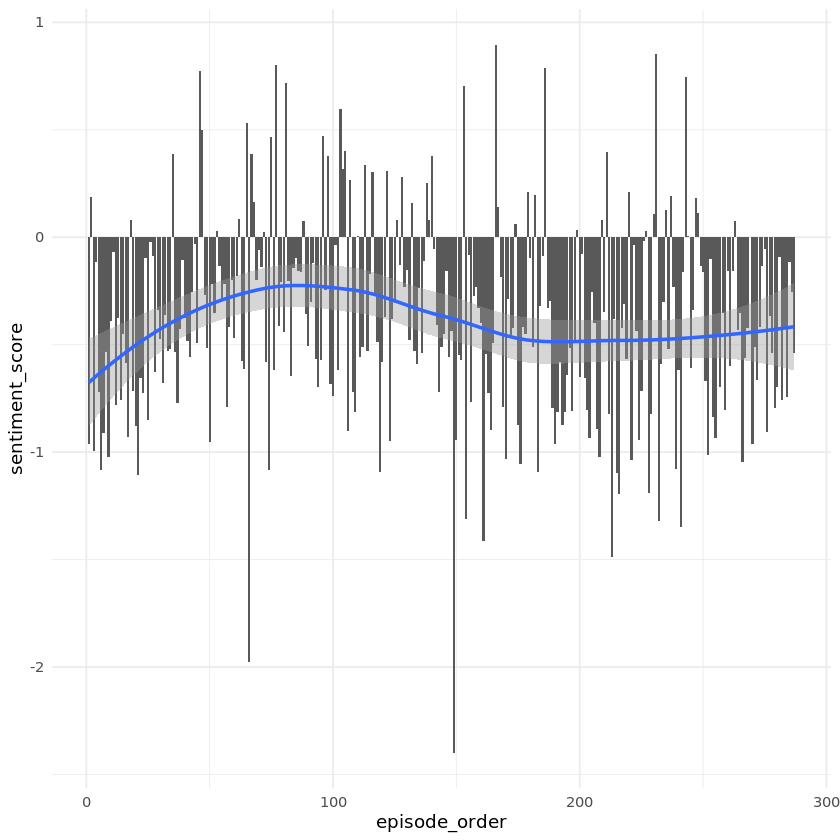

In [161]:
# Load the ggplot2
library(ggplot2)

# Set a minimal theme for all future plots
theme_set(theme_minimal())

# Plot sentiment score for each episode
ggplot(by_episode, aes(episode_order, sentiment_score)) +
       geom_col()+  
       geom_smooth()

## 5. South Park episode popularity
<p>The trend in the previous plot showed us that the sentiment changes over time. We can also see that most of the episodes have a <strong>negative</strong> mean sentiment score.</p>
<p>Let's now take a look at IMDB ratings. They tell us everything we need to analyze episode popularity. There's nothing better than a nice plot to see if the show is becoming more or less popular over time.</p>

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


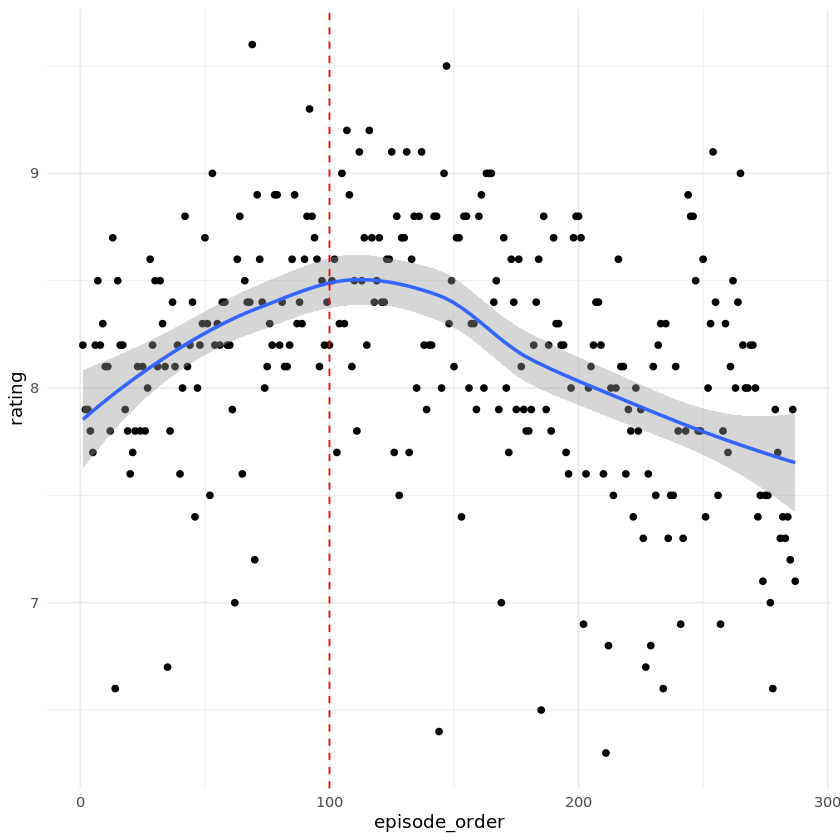

In [163]:
# Plot episode ratings
ggplot(by_episode, aes(episode_order, rating)) +
    geom_point() +
    geom_smooth() +
    geom_vline(xintercept = 100, col = "red", lty = "dashed")

## 6. Are naughty episodes more popular?
<p>South Park creators made a joke in the episode called <a href="https://en.wikipedia.org/wiki/Cancelled_(South_Park)">Cancelled</a> that a show shouldn't go past a 100 episodes. We saw that the popularity keeps dropping since then. But it's still a great show, trust me.</p>
<p>Let's take a look at something even more interesting though. I always wondered whether naughtier episodes are actually more popular. We have already prepared swear word ratio and episode rating in our <code>by_episode</code> data frame.</p>
<p><strong>Let's plot it then!</strong></p>

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


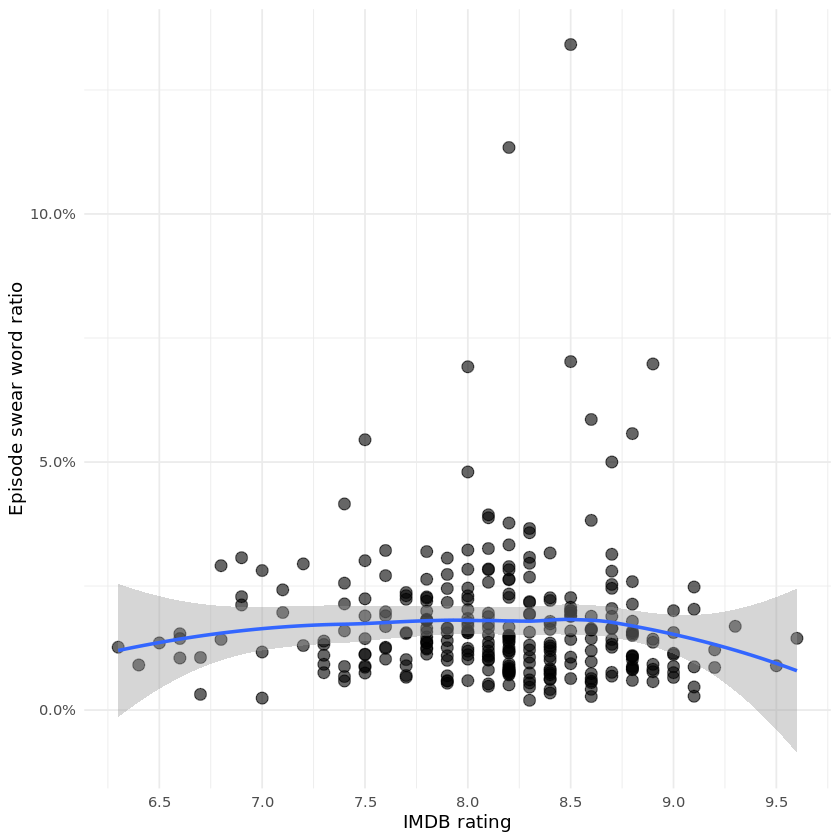

In [165]:
# Plot swear word ratio over episode rating
ggplot(by_episode, aes( rating,swear_word_ratio)) +
    geom_point(alpha = 0.6, size = 3) +
    geom_smooth()+
    scale_y_continuous(labels = scales::percent) +
    scale_x_continuous(breaks = seq(6, 10, 0.5)) +
    labs(
        x = "IMDB rating",
        y = "Episode swear word ratio"
)

## 7. Comparing profanity of two characters
<p>Right now, we will create a function that will help us decide which of the two characters is naughtier. We will need a <strong>2x2 matrix</strong> to compare them. The first column has to be the <strong>number of swear words</strong> and the second the <strong>number of non-swear words</strong>. Let's take a look at the following table. Those are real numbers for <em>Cartman</em> and <em>Butters</em>.</p>
<table>
<thead>
<tr>
<th></th>
<th>swear</th>
<th>non-swear</th>
</tr>
</thead>
<tbody>
<tr>
<td>Cartman</td>
<td>1318</td>
<td>48116</td>
</tr>
<tr>
<td>Butters</td>
<td>100</td>
<td>11412</td>
</tr>
</tbody>
</table>
<p>The final step will be to apply a statistical test. Because we are comparing proportions, we can use a base R function made exactly for this purpose. Meet <a href="https://www.rdocumentation.org/packages/stats/versions/3.5.1/topics/prop.test">prop.test</a>.</p>

In [167]:
# Create a function that compares profanity of two characters
compare_profanity <- function(char1, char2, words) {
    char_1 <- filter(words, character == char1)
    char_2 <- filter(words,character==char2)
    char_1_summary <- summarise(char_1, swear = sum(swear_word), total = n() - sum(swear_word))
    char_2_summary <- summarise(char_2, swear = sum(swear_word), total = n() - sum(swear_word))
    char_both_summary <- bind_rows(char_1_summary, char_2_summary)
    result <- prop.test(as.matrix(char_both_summary), correct = FALSE)
    return(broom::tidy(result) %>% bind_cols(character = char1))
}

## 8. Is Eric Cartman the naughtiest character?
<p>Anyone who knows the show might suspect that <strong>Eric Cartman</strong> is the naughtiest character. This is what I think too. We will know for sure very soon. I picked the top speaking characters for our analysis. These will be the most relevant to compare with Cartman. They are stored in the <code>characters</code> vector.</p>
<p>We will now use <code>map_df()</code> from <code>purrr</code> to easily compare profanity of Cartman with every character in our vector. Our function <code>compare_profanity()</code> always returns a data frame thanks to the <code>tidy()</code> function from <code>broom</code>.</p>
<p>The best way to answer the question is to create a nice plot again.</p>

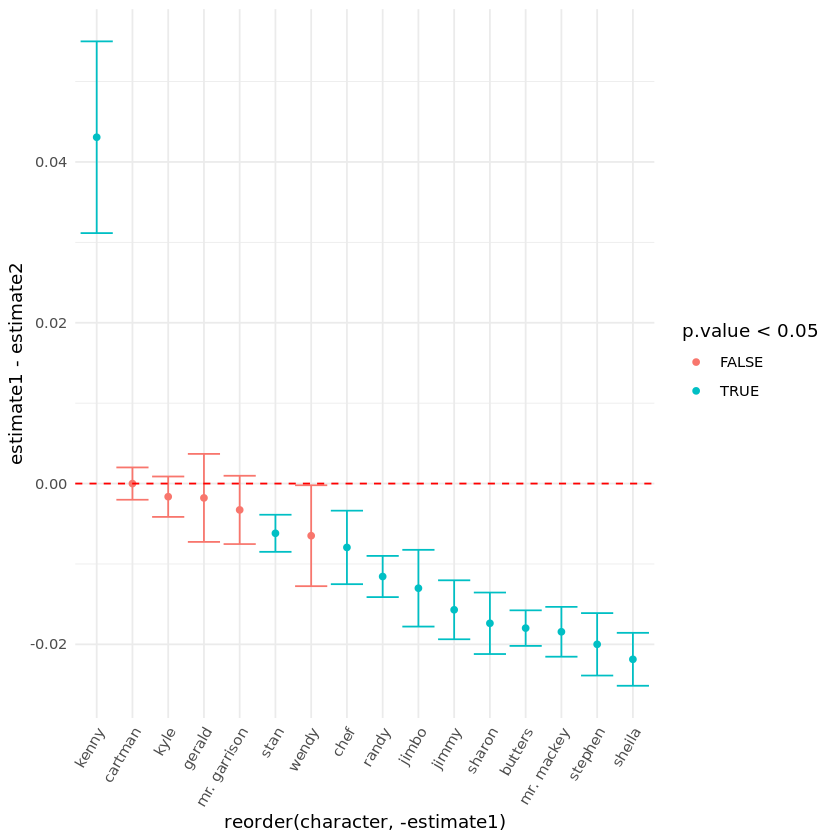

In [169]:
# Vector of most speaking characters in the show
characters <- c("butters", "cartman", "kenny", "kyle", "randy", "stan", "gerald", "mr. garrison",
                "mr. mackey", "wendy", "chef", "jimbo", "jimmy", "sharon", "sheila", "stephen")

# Map compare_profanity to all characters against Cartman
prop_result <- purrr::map_df(characters, compare_profanity, "cartman", sp_words)

# Plot estimate1-estimate2 confidence intervals of all characters and color it by a p.value threshold
ggplot(prop_result, aes(x = reorder(character, -estimate1), estimate1-estimate2, color = p.value < 0.05)) +
    geom_point() +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high), show.legend = FALSE) +
    geom_hline(yintercept = 0, col = "red", linetype = "dashed") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))

## 9. Let's answer some questions
<p>We included Eric Cartman in our <code>characters</code> vector so that we can easily compare him with the others. There are three main things that we should take into account when evaluating the above plot:</p>
<ol>
<li><strong>Spread of the error bar:</strong> the wider, the less words are spoken.</li>
<li><strong>Color of the error bar:</strong> blue is statistically significant result (p-value &lt; 0.05).</li>
<li><strong>Position of the error bar:</strong> prop.test estimate suggesting who is naughtier.</li>
</ol>
<p>Are we able to say if <strong>naughty episodes are more popular?</strong> And what about Eric Cartman, is he really the <strong>naughtiest character in South Park?</strong> And if not, <strong>who is it?</strong></p>

In [171]:
# Are naughty episodes more popular? TRUE/FALSE
naughty_episodes_more_popular <- FALSE

# Is Eric Cartman the naughtiest character? TRUE/FALSE
eric_cartman_naughtiest <- FALSE

# If he is, assign an empty string, otherwise write his name
who_is_naughtiest <- 'kenny'